In [ ]:
!pip install yahoofinance

In [2]:
import yfinance as yf

In [3]:
data=yf.download("ASELS.IS",
                 start="2000-01-01",
                 end="2023-08-31",
                 progress=False)

In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-05-10,9.409108,9.526721,9.173880,9.409108,5.171315,44552
2000-05-11,9.173880,9.173880,9.056266,9.173880,5.042033,20159
2000-05-12,9.056266,9.409108,9.056266,9.056266,4.977390,24227
2000-05-15,8.821038,9.056266,8.703424,8.821038,4.848109,27102
2000-05-16,8.703424,8.821038,8.468197,8.703424,4.783466,44044


In [5]:
len(data)

6010

In [7]:
data.dropna()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-05-10,9.409108,9.526721,9.173880,9.409108,5.171315,44552
2000-05-11,9.173880,9.173880,9.056266,9.173880,5.042033,20159
2000-05-12,9.056266,9.409108,9.056266,9.056266,4.977390,24227
2000-05-15,8.821038,9.056266,8.703424,8.821038,4.848109,27102
2000-05-16,8.703424,8.821038,8.468197,8.703424,4.783466,44044
...,...,...,...,...,...,...
2023-08-23,36.650002,37.349998,36.250000,36.375000,36.375000,104425132
2023-08-24,36.500000,38.674999,36.500000,37.000000,37.000000,186398638
2023-08-25,37.000000,38.380001,36.700001,37.779999,37.779999,83352906


In [8]:
#ROC değişim miktarı fonksiyonudur. Kapanış değerlerine bakarak bir önceki değerler üzerinden fark hesabı yapar.
def get_roc(close,n):
  fark=close.diff(n)
  onceki=close.shift(n)
  roc=(fark/onceki)*100
  return roc

In [9]:
#KST yi hesaplayalım.

def get_kst(close, sma1, sma2, sma3, sma4, roc1, roc2, roc3, roc4, signal):
  rcma1=get_roc(close, roc1).rolling(sma1).mean()
  rcma2=get_roc(close, roc2).rolling(sma2).mean()
  rcma3=get_roc(close, roc3).rolling(sma3).mean()
  rcma4=get_roc(close, roc4).rolling(sma4).mean()

  kst=(rcma1*1)+(rcma2*2)+(rcma3*3)+(rcma4*4)
  signal=kst.rolling(signal).mean()
  return kst, signal



In [11]:
  data["KST"], data["sinyal"] = get_kst(data["Close"],10, 10, 10,15, 10, 15, 20, 30, 9)
  data = data[data.index >= "2020-01-03"]
  data.tail()

<ipython-input-11-d423d0d1e02f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["KST"], data["sinyal"] = get_kst(data["Close"],10, 10, 10,15, 10, 15, 20, 30, 9)


,Open,High,Low,Close,Adj Close,Volume,KST,sinyal
Date,,,,,,,,
2023-08-23,36.650002,37.349998,36.250000,36.375000,36.375000,104425132,160.882206,226.938912
2023-08-24,36.500000,38.674999,36.500000,37.000000,37.000000,186398638,144.614287,212.325478
2023-08-25,37.000000,38.380001,36.700001,37.779999,37.779999,83352906,125.013319,196.361594
2023-08-28,38.099998,39.599998,38.099998,39.360001,39.360001,114588213,108.372349,179.000853
2023-08-29,39.419998,39.799999,38.259998,38.639999,38.639999,63295810,92.868322,161.811764


In [12]:
import tensorflow as tf
import keras

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


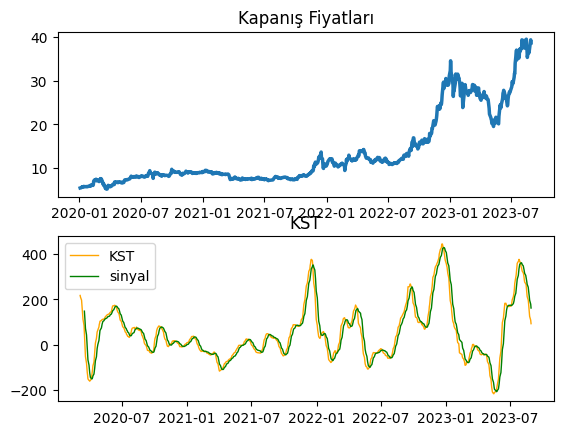

In [14]:
ax1=plt.subplot2grid((11,1), (0,0), rowspan =5, colspan=1)
ax2=plt.subplot2grid((11,1), (6,0), rowspan =5, colspan=1)
ax1.plot(data["Close"], linewidth=2.5)
ax1.set_title("Kapanış Fiyatları")
ax2.plot(data["KST"], linewidth =1, label ="KST", color = "orange")
ax2.plot(data["sinyal"], linewidth=1, label='sinyal', color ="green")
ax2.legend()
ax2.set_title("KST")
plt.show()


In [15]:
def kst_strategy (prices, kst_line, signal_line):
  buy_prices=[]
  sell_prices=[]
  kst_signal=[]
  sinyal=0

  for i in range (len(kst_line)):
    if kst_line[i-1] < signal_line[i-1] and kst_line[i]>signal_line[i]:
      if sinyal !=1:
        buy_prices.append(prices[i])
        sell_prices.append(np.nan)
        sinyal =1
        kst_signal.append(sinyal)
      else:
        buy_prices.append(np.nan)
        sell_prices.append(np.nan)
        kst_signal.append(0)

    elif kst_line[i-1] > signal_line[i-1] and kst_line[i] <signal_line[i]:
      if sinyal !=-1:
        buy_prices.append(np.nan)
        sell_prices.append(prices[i])
        sinyal=-1
        kst_signal.append(sinyal)
      else:
        buy_prices.append(np.nan)
        sell_prices.append(np.nan)
        kst_signal.append(0)

    else:
      buy_prices.append(np.nan)
      sell_prices.append(np.nan)
      kst_signal.append(0)

  return buy_prices, sell_prices, kst_signal

buy_prices, sell_prices, kst_signal = kst_strategy(data["Close"], data["KST"], data["sinyal"])

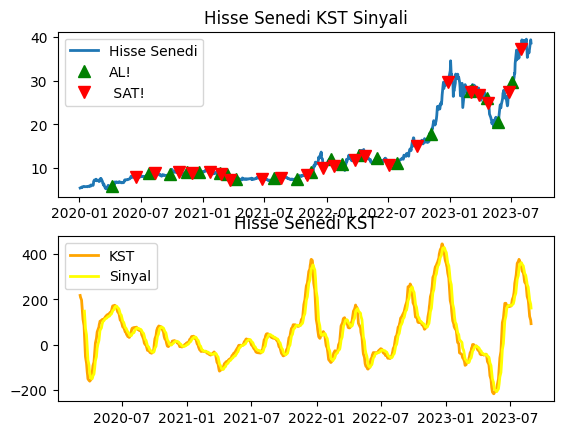

In [16]:
ax1=plt.subplot2grid((11,1), (0,0,), rowspan=5, colspan=1)
ax2=plt.subplot2grid((11,1), (6,0), rowspan=5, colspan=1)

ax1.plot(data["Close"], linewidth=2, label="Hisse Senedi")
ax1.plot(data.index, buy_prices, marker = "^", markersize=8, linewidth=0, color="green", label="AL!")
ax1.plot(data.index, sell_prices, marker="v", markersize=8, linewidth=0, color="red", label=" SAT!")
ax1.legend()

ax1.set_title("Hisse Senedi KST Sinyali")

ax2.plot(data["KST"], linewidth=2, label="KST", color="orange")
ax2.plot(data["sinyal"], linewidth=2, label="Sinyal", color="yellow")
ax2.legend()
ax2.set_title("Hisse Senedi KST")

plt.show()

In [17]:
  data["KST"], data["sinyal"] = get_kst(data["Close"],10, 10, 10,15, 10, 15, 20, 30, 9)
  data = data[data.index >= "2022-01-02"]
  data.tail()

,Open,High,Low,Close,Adj Close,Volume,KST,sinyal
Date,,,,,,,,
2023-08-23,36.650002,37.349998,36.250000,36.375000,36.375000,104425132,160.882206,226.938912
2023-08-24,36.500000,38.674999,36.500000,37.000000,37.000000,186398638,144.614287,212.325478
2023-08-25,37.000000,38.380001,36.700001,37.779999,37.779999,83352906,125.013319,196.361594
2023-08-28,38.099998,39.599998,38.099998,39.360001,39.360001,114588213,108.372349,179.000853
2023-08-29,39.419998,39.799999,38.259998,38.639999,38.639999,63295810,92.868322,161.811764


Text(0, 0.5, 'hareket')

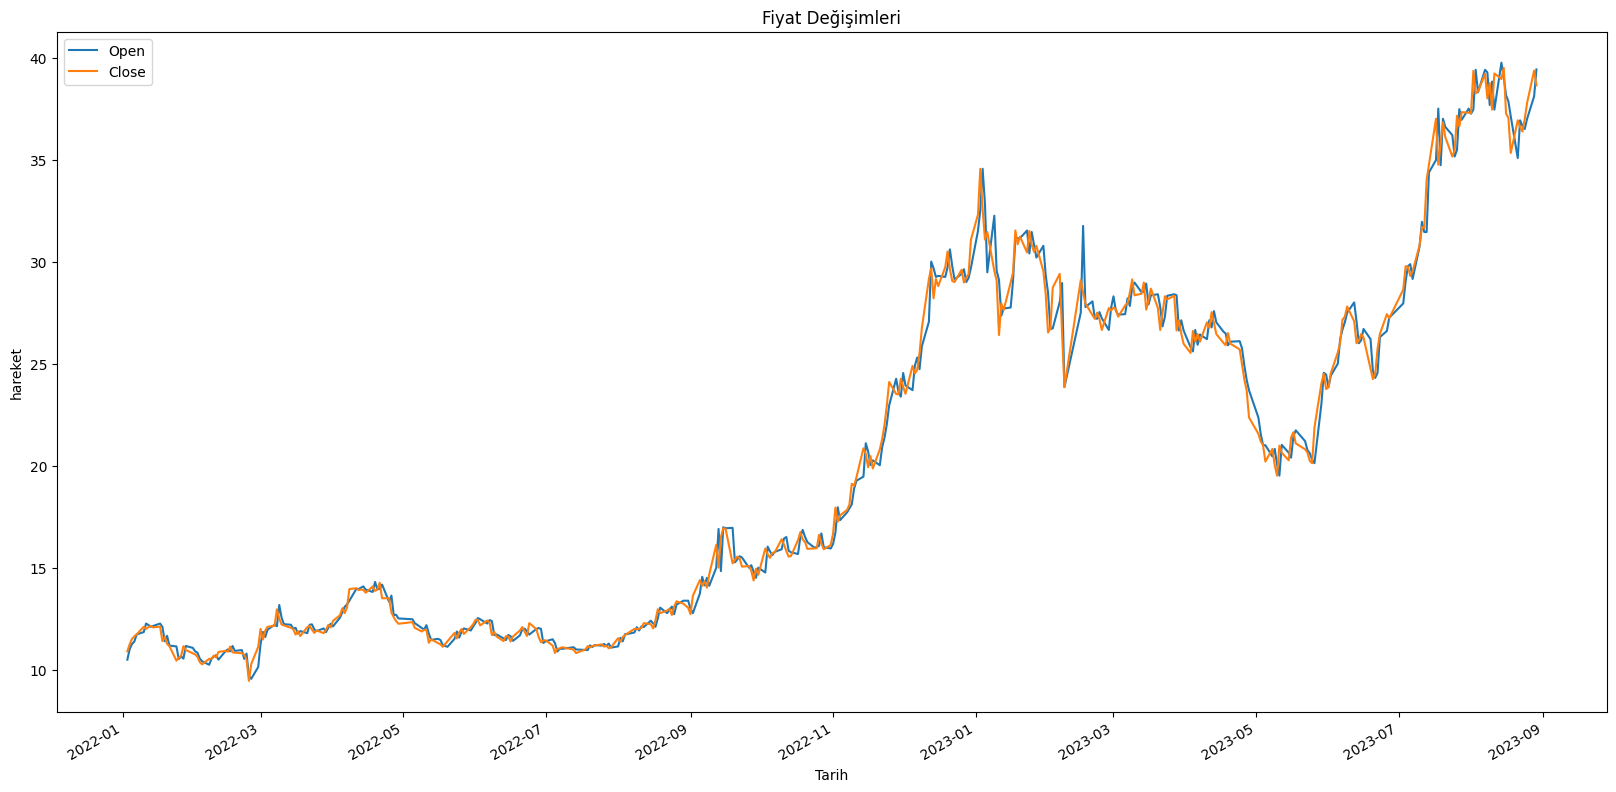

In [18]:
data[['Open','Close']].plot(figsize = (20,10), alpha = 1)
plt.title('Fiyat Değişimleri')
plt.xlabel('Tarih')
plt.ylabel('hareket')

Text(0, 0.5, 'Hareket')

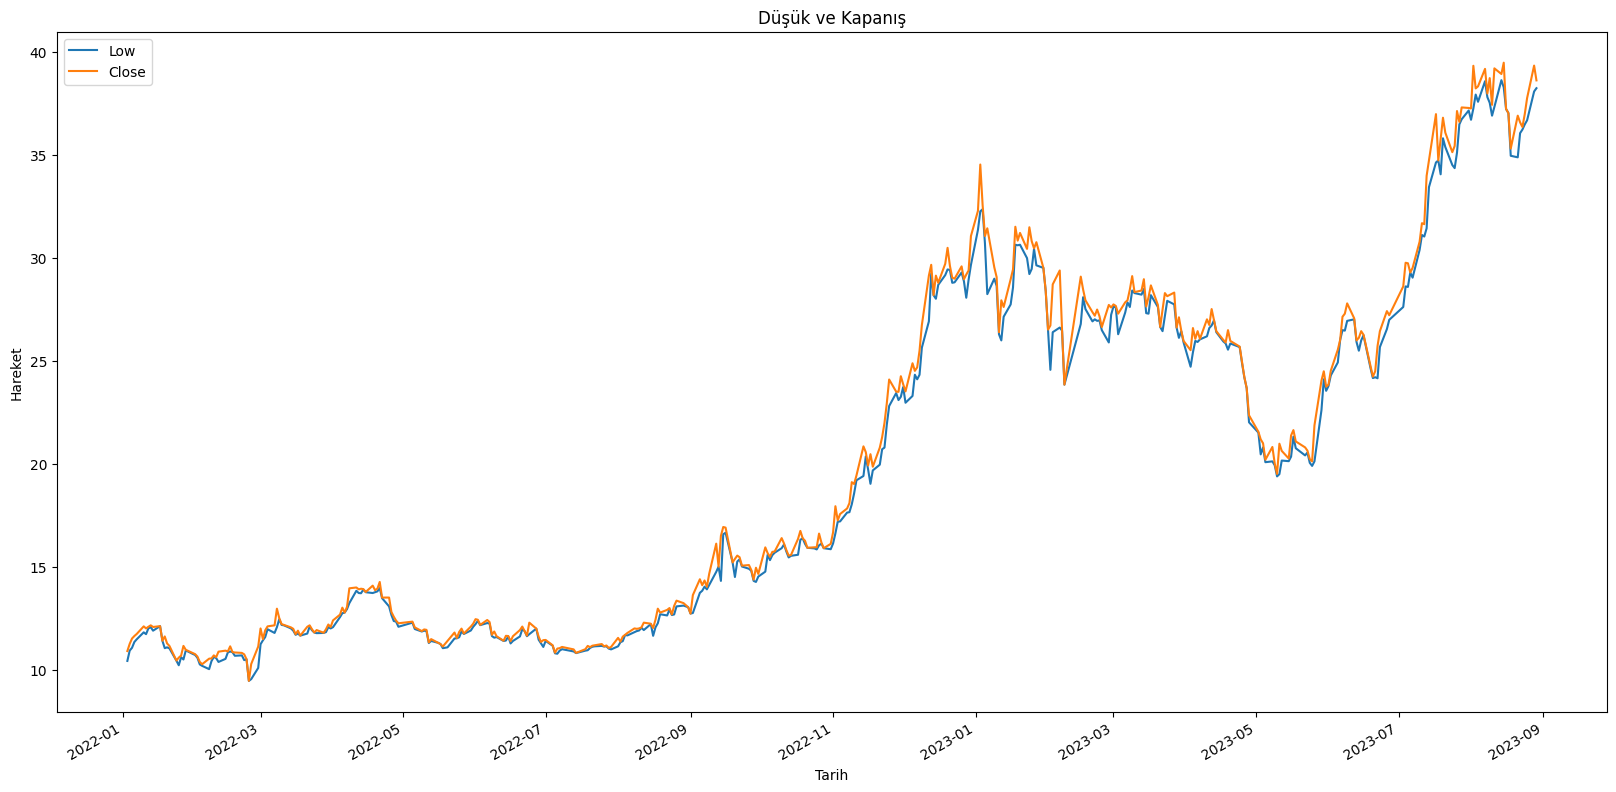

In [19]:
data[['Low','Close']].plot(figsize = (20,10), alpha = 1)
plt.title('Düşük ve Kapanış')
plt.xlabel('Tarih')
plt.ylabel('Hareket')

Text(0, 0.5, 'Hareket')

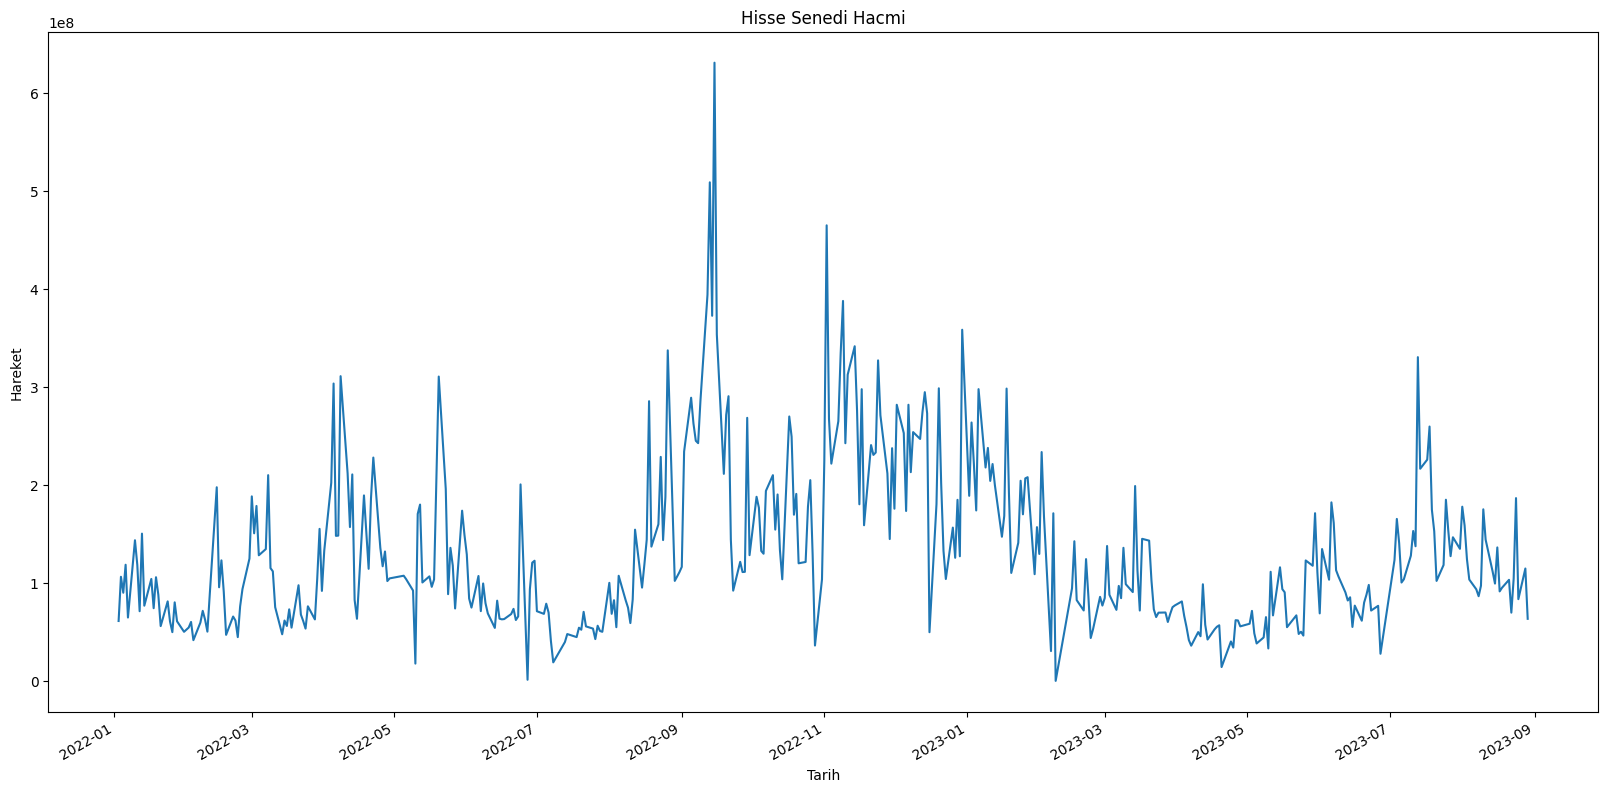

In [20]:
data['Volume'].plot(figsize = (20,10), alpha = 1)
plt.title('Hisse Senedi Hacmi')
plt.xlabel('Tarih')
plt.ylabel('Hareket')

In [21]:
veri=data

In [22]:
veri.head()

,Open,High,Low,Close,Adj Close,Volume,KST,sinyal
Date,,,,,,,,
2022-01-03,10.49,10.90,10.42,10.90,10.793091,61064146,85.514622,207.022951
2022-01-04,11.01,11.39,10.92,11.25,11.139658,106163426,67.260399,178.193896
2022-01-05,11.26,11.55,11.06,11.51,11.397108,89890050,57.512011,151.994477
2022-01-06,11.38,11.88,11.34,11.63,11.515931,118434816,45.578580,126.969135
2022-01-07,11.73,11.84,11.47,11.73,11.614949,64605930,35.320471,104.012680


In [23]:
veri.head()

,Open,High,Low,Close,Adj Close,Volume,KST,sinyal
Date,,,,,,,,
2022-01-03,10.49,10.90,10.42,10.90,10.793091,61064146,85.514622,207.022951
2022-01-04,11.01,11.39,10.92,11.25,11.139658,106163426,67.260399,178.193896
2022-01-05,11.26,11.55,11.06,11.51,11.397108,89890050,57.512011,151.994477
2022-01-06,11.38,11.88,11.34,11.63,11.515931,118434816,45.578580,126.969135
2022-01-07,11.73,11.84,11.47,11.73,11.614949,64605930,35.320471,104.012680


In [24]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from datetime import datetime

In [25]:
def predict_stock_price():
    # Read data
    df = veri

    # Get close price data
    data = df.filter(['Close']).values

    # Scale data between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split data into training and testing sets
    training_data_len = int(len(data) * 0.8)
    train_data = scaled_data[0:training_data_len, :]
    x_train = []
    y_train = []

    for i in range(10, len(train_data)):
        x_train.append(train_data[i - 10:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # Datayı LSTM verilerine göre dönüştürüyoruz
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # LSTM Modelimizi oluşturuyoruz
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(tf.keras.layers.LSTM(100, return_sequences=False))
    model.add(tf.keras.layers.Dense(25))
    model.add(tf.keras.layers.Dense(1))

    # Modeli optimize ederek eğitiyoruz
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=32, epochs=100)

    # Verileri test ediyoruz
    test_data = scaled_data[training_data_len - 10:, :]
    x_test = []
    y_test = data[training_data_len:, :]

    for i in range(10, len(test_data)):
        x_test.append(test_data[i - 10:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Make predictions
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Gelecek trendi tahmin ettiriyoruz (düşecek mi yükselecek mi)
    future_data = df.filter(['Close'])
    last_60_days = future_data[-10:].values
    last_60_days_scaled = scaler.transform(last_60_days)
    X_test = []
    X_test.append(last_60_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    future_prediction = model.predict(X_test)
    future_prediction = scaler.inverse_transform(future_prediction)
    print('Gelecek Gün Tahminleri:', future_prediction[0][0])

    # Gelecek 10 gün için tahmin yaptırıyoruz.
    future_data = df.filter(['Close'])
    last_X_days = future_data[-1000:] #  Burada son 1000 gün geriye bakarak tahmin yapıyor.
    last_X_days_scaled = scaler.transform(last_X_days)
    X_test = []
    X_test.append(last_X_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_prices = []
    for i in range(10):
        predicted_price = model.predict(X_test)
        predicted_prices.append(predicted_price[0][0])
        X_test = np.append(X_test, [predicted_price], axis=1)

    # tahmin fiyatları sıralayalım
    predicted_prices = np.array(predicted_prices).reshape(-1, 1)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    # Tahmini fiyatların yazımı
    print(predicted_prices)

    today = datetime.now().strftime("%Y-%m-%d")
    filename = 'predicted_prices.xlsx'

    df_predicted = pd.DataFrame(predicted_prices.reshape(1, -1), columns=['Day ' + str(i) for i in range(1, 11)])
    df_predicted.index = [today]

    if not Path(filename).is_file():
        df_predicted.to_excel(filename)
        print("Yeni veriler eklendi")
    else:
        df_existing = pd.read_excel(filename, index_col=0)
        df_combined = pd.concat([df_existing, df_predicted], axis=0)
        df_combined.to_excel(filename)
        print("Yeni veriler Oluşturuldu ve Eklendi")

In [26]:
predict_stock_price()

Epoch 1/100
11/11 [==============================] - 5s 24ms/step - loss: 0.0313 - accuracy: 0.0031
Epoch 2/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0090 - accuracy: 0.0031
Epoch 3/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0032 - accuracy: 0.0031
Epoch 4/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0019 - accuracy: 0.0031
Epoch 5/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0019 - accuracy: 0.0031
Epoch 6/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0017 - accuracy: 0.0031
Epoch 7/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0017 - accuracy: 0.0031
Epoch 8/100
11/11 [==============================] - 0s 26ms/step - loss: 0.0016 - accuracy: 0.0031
Epoch 9/100
11/11 [==============================] - 0s 24ms/step - loss: 0.0017 - accuracy: 0.0031
Epoch 10/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0021 - accuracy: 0.0031

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step
[[39.318462]
 [39.53771 ]
 [39.70499 ]
 [39.828255]
 [39.923367]
 [40.004436]
 [40.08147 ]
 [40.16031 ]
 [40.24334 ]
 [40.330494]]
Yeni veriler eklendi


In [ ]:
veri

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-05-10,9.409108,9.526721,9.173880,9.409108,7.294799,44552
2000-05-11,9.173880,9.173880,9.056266,9.173880,7.112428,20159
2000-05-12,9.056266,9.409108,9.056266,9.056266,7.021242,24227
2000-05-15,8.821038,9.056266,8.703424,8.821038,6.838871,27102
2000-05-16,8.703424,8.821038,8.468197,8.703424,6.747687,44044
...,...,...,...,...,...,...
2023-07-20,74.000000,74.599998,71.650002,73.650002,73.650002,76305040
2023-07-21,73.199997,73.400002,70.800003,72.199997,72.199997,50971822
2023-07-24,72.400002,73.400002,69.050003,70.300003,70.300003,59090275
